In [39]:
# Importing the modules and libraries
# Additional libraries should be imported in this cell for organization

from datetime import datetime
import numpy as np
from numpy import array
import matplotlib.pyplot as plt
from matplotlib.pylab import rcParams
import matplotlib.dates as mdates
import pandas as pd
from pandas.plotting import autocorrelation_plot
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import load_model
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.layers import LSTM
from keras.layers import Bidirectional
from keras.layers import RepeatVector
from keras.layers import TimeDistributed
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import LabelEncoder
from scikeras.wrappers import KerasRegressor
from sklearn.model_selection import GridSearchCV
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.model_selection import train_test_split
import pmdarima as pm
from pmdarima.arima import ADFTest
from dateutil.relativedelta import relativedelta, MO
import matplotlib.dates as mdates
import seaborn as sns

In [40]:
# fix random seed for reproducibility
tf.random.set_seed(7)

In [41]:
# Reading the datasets and creating the dataframes

dataset = pd.read_csv("Amiens.csv", skiprows=10, skipfooter=10, engine='python')
df_Amiens = pd.DataFrame(dataset)

dataset = pd.read_csv("Compiegne.csv", skiprows=10, skipfooter=10, engine='python')
df_Compiegne = pd.DataFrame(dataset)

print(df_Amiens.head())
print(df_Compiegne.head())

            time    P  G(i)  H_sun   T2m  WS10m  Int
0  20210101:0010  0.0   0.0    0.0 -1.60   1.79  0.0
1  20210101:0110  0.0   0.0    0.0 -1.72   1.79  0.0
2  20210101:0210  0.0   0.0    0.0 -1.90   1.79  0.0
3  20210101:0310  0.0   0.0    0.0 -1.79   1.79  0.0
4  20210101:0410  0.0   0.0    0.0 -1.52   1.72  0.0
            time    P  G(i)  H_sun   T2m  WS10m  Int
0  20210101:0010  0.0   0.0    0.0 -0.21   1.59  0.0
1  20210101:0110  0.0   0.0    0.0 -0.44   1.59  0.0
2  20210101:0210  0.0   0.0    0.0 -0.48   1.38  0.0
3  20210101:0310  0.0   0.0    0.0 -0.47   1.24  0.0
4  20210101:0410  0.0   0.0    0.0 -0.50   1.24  0.0


In [42]:
df_Amiens['time'] = pd.to_datetime(df_Amiens['time'].str.replace(':', ''), format='%Y%m%d%H%M', infer_datetime_format=True)
df_Amiens = df_Amiens.set_index(['time'])

df_Compiegne['time'] = pd.to_datetime(df_Compiegne['time'].str.replace(':', ''), format='%Y%m%d%H%M', infer_datetime_format=True)
df_Compiegne = df_Compiegne.set_index(['time'])

print(df_Amiens.head())
print(df_Compiegne.head())

                       P  G(i)  H_sun   T2m  WS10m  Int
time                                                   
2021-01-01 00:10:00  0.0   0.0    0.0 -1.60   1.79  0.0
2021-01-01 01:10:00  0.0   0.0    0.0 -1.72   1.79  0.0
2021-01-01 02:10:00  0.0   0.0    0.0 -1.90   1.79  0.0
2021-01-01 03:10:00  0.0   0.0    0.0 -1.79   1.79  0.0
2021-01-01 04:10:00  0.0   0.0    0.0 -1.52   1.72  0.0
                       P  G(i)  H_sun   T2m  WS10m  Int
time                                                   
2021-01-01 00:10:00  0.0   0.0    0.0 -0.21   1.59  0.0
2021-01-01 01:10:00  0.0   0.0    0.0 -0.44   1.59  0.0
2021-01-01 02:10:00  0.0   0.0    0.0 -0.48   1.38  0.0
2021-01-01 03:10:00  0.0   0.0    0.0 -0.47   1.24  0.0
2021-01-01 04:10:00  0.0   0.0    0.0 -0.50   1.24  0.0


C:\Users\ugurhan\AppData\Local\Temp\ipykernel_25824\4185528883.py:1: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  df_Amiens['time'] = pd.to_datetime(df_Amiens['time'].str.replace(':', ''), format='%Y%m%d%H%M', infer_datetime_format=True)
C:\Users\ugurhan\AppData\Local\Temp\ipykernel_25824\4185528883.py:4: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  df_Compiegne['time'] = pd.to_datetime(df_Compiegne['time'].str.replace(':', ''), format='%Y%m%d%H%M', infer_datetime_format=True)


In [43]:
df_Amiens_Temp = df_Amiens.iloc[:, [1, 3]]

print(df_Amiens_Temp.head())

df_Compiegne_Temp = df_Compiegne.iloc[:, [1, 3]]

print(df_Compiegne_Temp.head())

                     G(i)   T2m
time                           
2021-01-01 00:10:00   0.0 -1.60
2021-01-01 01:10:00   0.0 -1.72
2021-01-01 02:10:00   0.0 -1.90
2021-01-01 03:10:00   0.0 -1.79
2021-01-01 04:10:00   0.0 -1.52
                     G(i)   T2m
time                           
2021-01-01 00:10:00   0.0 -0.21
2021-01-01 01:10:00   0.0 -0.44
2021-01-01 02:10:00   0.0 -0.48
2021-01-01 03:10:00   0.0 -0.47
2021-01-01 04:10:00   0.0 -0.50


# Training the Model

In [44]:
# convert history into inputs and outputs
def to_supervised(train, n_input, n_out=1):
	# flatten data
	data = train.reshape((train.shape[0]*train.shape[1], train.shape[2]))
	X, y = list(), list()
	in_start = 0
	# step over the entire history one time step at a time
	for _ in range(len(data)):
		# define the end of the input sequence
		in_end = in_start + n_input
		out_end = in_end + n_out
		# ensure we have enough data for this instance
		if out_end <= len(data):
			X.append(data[in_start:in_end, :])
			y.append(data[in_end:out_end, 1]) # Whichever feature needs to be predicted
		# move along one time step
		in_start += 1
	return array(X), array(y)

In [45]:
def forecast(model, history, n_input):
	# flatten data
	data = array(history)
	data = data.reshape((data.shape[0]*data.shape[1], data.shape[2]))
	# retrieve last observations for input data
	input_x = data[-n_input:, :]

	# reshape into [1, n_input, n]
	input_x = input_x.reshape((1, input_x.shape[0], input_x.shape[1]))
	# forecast the next week
	yhat = model.predict(input_x, verbose=0)

	# we only want the vector forecast
	yhat = yhat[0]
	return yhat

In [46]:
def reframe_datasets(training, testing):

	# restructure into windows of hourly data
	train = array(np.split(training, len(training)/1))
	test = array(np.split(testing, len(testing)/1))

	return train, test

In [47]:
# train the model
def build_model(train, n_input):
	# prepare data
	train_x, train_y = to_supervised(train, n_input)

	# define parameters
	verbose, epochs, batch_size = 2, 100, 144
	n_timesteps, n_features, n_outputs = train_x.shape[1], train_x.shape[2], train_y.shape[1]
	# reshape output into [samples, timesteps, features]
	train_y = train_y.reshape((train_y.shape[0], train_y.shape[1], 1))
	# define model
	model = Sequential()
	model.add(LSTM(150, activation='relu', input_shape=(n_timesteps, n_features)))
	model.add(RepeatVector(n_outputs))
	model.add(LSTM(150, activation='relu', return_sequences=True))
	model.add(TimeDistributed(Dense(100, activation='relu')))
	model.add(TimeDistributed(Dense(1)))
	model.compile(loss='mse', optimizer='adam')
	# fit network
	model.fit(train_x, train_y, epochs=epochs, batch_size=batch_size, verbose=verbose)
	return model

In [48]:
# Evaluate forecasts against expected values
def evaluate_forecasts(actual, predicted):
	scores = list()
	# calculate an RMSE score for each day
	for i in range(actual.shape[1]):
		# calculate mse
		mse = mean_squared_error(actual[:, i], predicted[:, i])
		# calculate rmse
		rmse = np.sqrt(mse)
		# store
		scores.append(rmse)
	# calculate overall RMSE
	s = 0
	for row in range(actual.shape[0]):
		for col in range(actual.shape[1]):
			s += (actual[row, col] - predicted[row, col])**2
	score = np.sqrt(s / (actual.shape[0] * actual.shape[1]))
	return score, scores

In [49]:
"""
# resample data to daily
hourly_groups = df_All_Loc.resample('H')
hourly_data_training = hourly_groups.sum()

# summarize
print(hourly_data_training.shape)
print(hourly_data_training.head())

# resample data to daily
hourly_groups_testing = df_Compiegne_Temp.resample('H')
hourly_data_testing = hourly_groups_testing.sum()

# summarize
print(hourly_data_testing.shape)
print(hourly_data_testing.head())
"""

"\n# resample data to daily\nhourly_groups = df_All_Loc.resample('H')\nhourly_data_training = hourly_groups.sum()\n\n# summarize\nprint(hourly_data_training.shape)\nprint(hourly_data_training.head())\n\n# resample data to daily\nhourly_groups_testing = df_Compiegne_Temp.resample('H')\nhourly_data_testing = hourly_groups_testing.sum()\n\n# summarize\nprint(hourly_data_testing.shape)\nprint(hourly_data_testing.head())\n"

In [50]:
"""
# save
hourly_data_training.to_csv('Hourly_Temp_Prediction_Training.csv')
hourly_data_testing.to_csv('Hourly_Temp_Prediction_Testing.csv')
"""

"\n# save\nhourly_data_training.to_csv('Hourly_Temp_Prediction_Training.csv')\nhourly_data_testing.to_csv('Hourly_Temp_Prediction_Testing.csv')\n"

In [51]:
"""
# load the new file
dataset_training = pd.read_csv('Hourly_Temp_Prediction_Training.csv', header=0, infer_datetime_format=True, parse_dates=['time'], index_col=['time'])
dataset_testing = pd.read_csv('Hourly_Temp_Prediction_Testing.csv', header=0, infer_datetime_format=True, parse_dates=['time'], index_col=['time'])
"""

dataset_training = df_Amiens_Temp
dataset_testing = df_Compiegne_Temp

# Preparing dataset for LSTM training

df_lstm_training = dataset_training.values
df_lstm_training = df_lstm_training.astype('float32')

df_lstm_testing = dataset_testing.values
df_lstm_testing = df_lstm_testing.astype('float32')

# Normalize the dataset
# Normalizing the dataset is important for problems like the exploding gradient problem

scaler = MinMaxScaler(feature_range=(0, 1))
df_lstm_training = scaler.fit_transform(df_lstm_training)

scaler = MinMaxScaler(feature_range=(0, 1))
df_lstm_testing = scaler.fit_transform(df_lstm_testing)

train, test = reframe_datasets(df_lstm_training, df_lstm_testing)

# Build a model
n_input = 1
model = build_model(train, n_input)

d:\Users\ugurhan\Desktop\LSTM Model\.venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/100
183/183 - 6s - 35ms/step - loss: 0.0205
Epoch 2/100
183/183 - 3s - 15ms/step - loss: 2.4694e-04
Epoch 3/100
183/183 - 3s - 15ms/step - loss: 2.4232e-04
Epoch 4/100
183/183 - 3s - 15ms/step - loss: 2.4095e-04
Epoch 5/100
183/183 - 3s - 15ms/step - loss: 2.4066e-04
Epoch 6/100
183/183 - 3s - 15ms/step - loss: 2.3967e-04
Epoch 7/100
183/183 - 3s - 15ms/step - loss: 2.3837e-04
Epoch 8/100
183/183 - 3s - 15ms/step - loss: 2.3765e-04
Epoch 9/100
183/183 - 3s - 16ms/step - loss: 2.3726e-04
Epoch 10/100
183/183 - 3s - 16ms/step - loss: 2.3705e-04
Epoch 11/100
183/183 - 3s - 16ms/step - loss: 2.3725e-04
Epoch 12/100
183/183 - 3s - 15ms/step - loss: 2.3754e-04
Epoch 13/100
183/183 - 3s - 15ms/step - loss: 2.3777e-04
Epoch 14/100
183/183 - 3s - 16ms/step - loss: 2.3824e-04
Epoch 15/100
183/183 - 3s - 15ms/step - loss: 2.3902e-04
Epoch 16/100
183/183 - 3s - 15ms/step - loss: 2.3980e-04
Epoch 17/100
183/183 - 3s - 16ms/step - loss: 2.4058e-04
Epoch 18/100
183/183 - 3s - 15ms/step - loss

# Testing the Model

In [52]:
# summarize scores
def summarize_scores(name, score, scores):
	s_scores = ', '.join(['%.1f' % s for s in scores])
	print('%s: [%.3f] %s' % (name, score, s_scores))

In [53]:
# evaluate a single model
def evaluate_model(model, train, test, n_input, scaler):

	# history is a list of daily data
	history = [x for x in train]

	# walk-forward validation over each day
	predictions = list()

	for i in range(len(test)):

		# predict the day
		yhat_sequence = forecast(model, history, n_input)

		# store the predictions
		predictions.append(yhat_sequence)

		# get real observation and add to history for predicting the next day
		history.append(test[i, :])

	# evaluate predictions hours for each day
	predictions = array(predictions)

	# Reshape `predictions` before inverse transform
	n_samples, n_timesteps, n_features = predictions.shape
	predictions_reshaped = predictions.reshape(n_samples * n_timesteps, n_features)
	
    # Create a scaler for the target feature only
	target_scaler = MinMaxScaler(feature_range=(0, 1))
	
    # Initialize its internal parameters using the ones from the full scaler
	target_scaler.min_ = scaler.min_[1].reshape(1,)
	target_scaler.scale_ = scaler.scale_[1].reshape(1,)
	target_scaler.data_min_ = scaler.data_min_[1].reshape(1,)
	target_scaler.data_max_ = scaler.data_max_[1].reshape(1,)
	target_scaler.data_range_ = scaler.data_range_[1].reshape(1,)

	predictions_reshaped = target_scaler.inverse_transform(predictions_reshaped)
	predictions = predictions_reshaped.reshape(n_samples, n_timesteps, n_features)

	print(np.shape(predictions))

	# Reshape `test` before inverse transform
	n_samples, n_timesteps, n_features = test.shape
	test_reshaped = test.reshape(n_samples * n_timesteps, n_features)

	test_reshaped = scaler.inverse_transform(test_reshaped)
		
	test = test_reshaped.reshape(n_samples, n_timesteps, n_features)		
	
	score, scores = evaluate_forecasts(test[:, :, 1], predictions)
	return predictions, score, scores

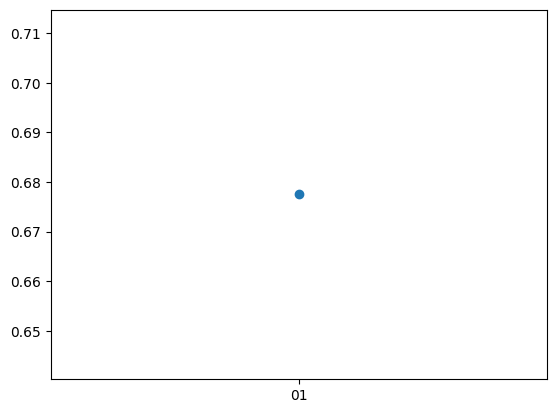

In [ ]:
# Evaluate model and get scores
predictions, score, scores = evaluate_model(model, train, test, n_input, scaler)

print(predictions)

# summarize scores
summarize_scores('lstm', score, scores)

# plot scores
hours = ['01']
plt.plot(hours, scores, marker='o', label='lstm')
plt.show()

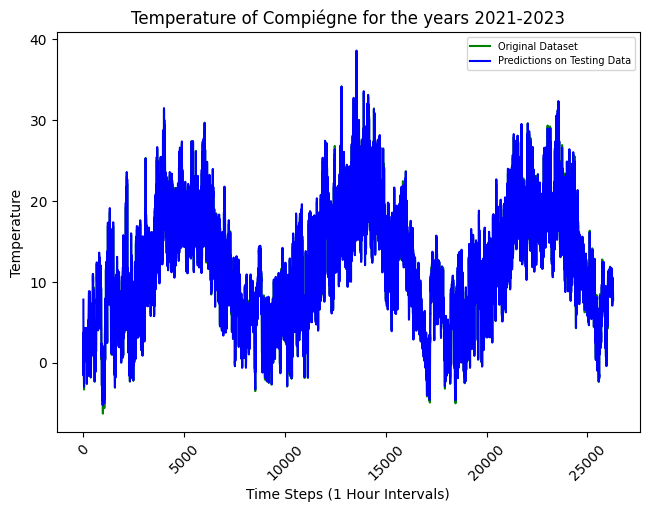

In [56]:
flattened_predictions = predictions.flatten()

# Plot baseline and predictions

plt.plot(dataset_testing['T2m'].values, 'g', label='Original Dataset')
plt.plot(flattened_predictions, 'b', label='Predictions on Testing Data')
plt.legend(fontsize=7)

plt.xticks(rotation=45)  # Rotate x-axis labels for clarity
plt.tight_layout()  # Adjust layout to prevent clipping
plt.xlabel('Time Steps (1 Hour Intervals)')
plt.ylabel('Temperature')
plt.title('Temperature of Compiégne for the years 2021-2023')
plt.show()

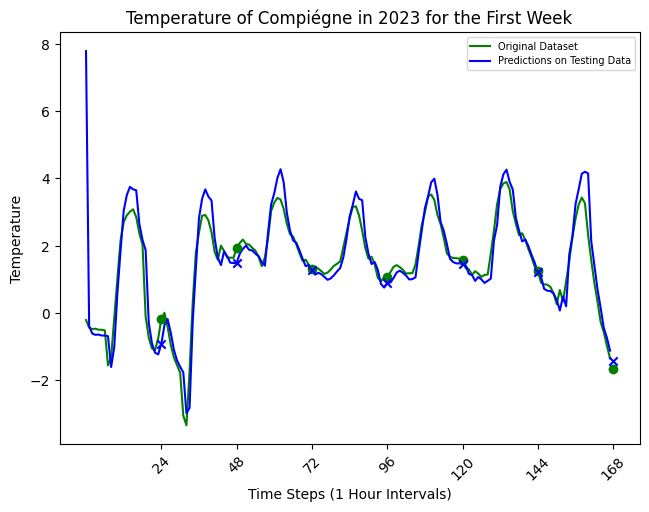

In [57]:
# Plot baseline and predictions for the first 168 timesteps
plt.plot(dataset_testing['T2m'].values[:168], 'g', label='Original Dataset')  # Slice the first 168 timesteps
plt.plot(flattened_predictions[:168], 'b', label='Predictions on Testing Data')  # Slice the first 168 timesteps

# Define the tick positions and labels
tick_positions = [24, 48, 72, 96, 120, 144, 168]
tick_labels = [str(tick) for tick in tick_positions]  # Convert to strings for labeling

# Get the y-values corresponding to the x-tick positions
original_y_values = dataset_testing['T2m'].values[tick_positions]
predicted_y_values = flattened_predictions[tick_positions]

# Add pins (markers) at xtick locations
plt.scatter(tick_positions, original_y_values, color='g', marker='o', zorder=3)
plt.scatter(tick_positions, predicted_y_values, color='blue', marker='x', zorder=3)

# Customize the plot
plt.legend(fontsize=7)
plt.xticks(tick_positions, tick_labels, rotation=45)  # Set tick positions and labels
plt.tight_layout()  # Adjust layout to prevent clipping
plt.xlabel('Time Steps (1 Hour Intervals)')
plt.ylabel('Temperature')
plt.title('Temperature of Compiégne in 2023 for the First Week')
plt.show()

The bottom graph belongs to the model with n_input = 24

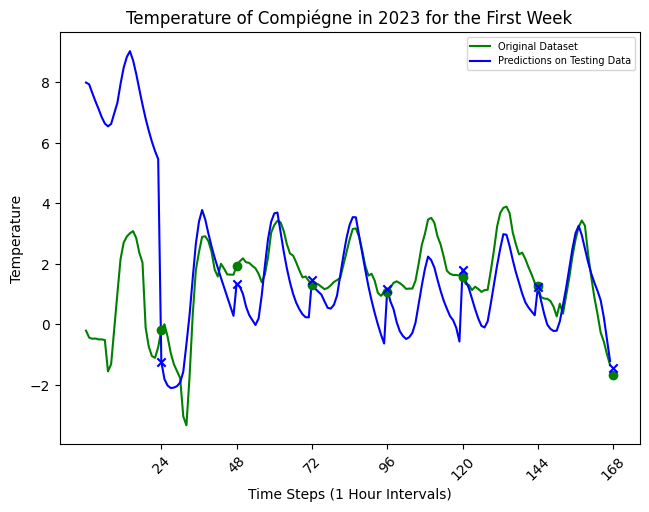

In [ ]:
"""
# Plot baseline and predictions for the first 168 timesteps
plt.plot(dataset_testing['T2m'].values[:168], 'g', label='Original Dataset')  # Slice the first 168 timesteps
plt.plot(flattened_predictions[:168], 'b', label='Predictions on Testing Data')  # Slice the first 168 timesteps

# Define the tick positions and labels
tick_positions = [24, 48, 72, 96, 120, 144, 168]
tick_labels = [str(tick) for tick in tick_positions]  # Convert to strings for labeling

# Get the y-values corresponding to the x-tick positions
original_y_values = dataset_testing['T2m'].values[tick_positions]
predicted_y_values = flattened_predictions[tick_positions]

# Add pins (markers) at xtick locations
plt.scatter(tick_positions, original_y_values, color='g', marker='o', zorder=3)
plt.scatter(tick_positions, predicted_y_values, color='blue', marker='x', zorder=3)

# Customize the plot
plt.legend(fontsize=7)
plt.xticks(tick_positions, tick_labels, rotation=45)  # Set tick positions and labels
plt.tight_layout()  # Adjust layout to prevent clipping
plt.xlabel('Time Steps (1 Hour Intervals)')
plt.ylabel('Temperature')
plt.title('Temperature of Compiégne in 2023 for the First Week')
plt.show()
"""

# Paralel Testing

In [15]:
# Reading the datasets and creating the dataframes

dataset = pd.read_csv("Amiens.csv", skiprows=10, skipfooter=10, engine='python')
df_Amiens = pd.DataFrame(dataset)

dataset = pd.read_csv("Compiegne.csv", skiprows=10, skipfooter=10, engine='python')
df_Compiegne = pd.DataFrame(dataset)

dataset = pd.read_csv("Le_Mans.csv", skiprows=10, skipfooter=10, engine='python')
df_LeMans = pd.DataFrame(dataset)

dataset = pd.read_csv("Reims.csv", skiprows=10, skipfooter=10, engine='python')
df_Reims = pd.DataFrame(dataset)

dataset = pd.read_csv("Troyes.csv", skiprows=10, skipfooter=10, engine='python')
df_Troyes = pd.DataFrame(dataset)

print(df_Amiens.head())
print(df_Compiegne.head())
print(df_LeMans.head())
print(df_Reims.head())
print(df_Troyes.head())

            time    P  G(i)  H_sun   T2m  WS10m  Int
0  20210101:0010  0.0   0.0    0.0 -1.60   1.79  0.0
1  20210101:0110  0.0   0.0    0.0 -1.72   1.79  0.0
2  20210101:0210  0.0   0.0    0.0 -1.90   1.79  0.0
3  20210101:0310  0.0   0.0    0.0 -1.79   1.79  0.0
4  20210101:0410  0.0   0.0    0.0 -1.52   1.72  0.0
            time    P  G(i)  H_sun   T2m  WS10m  Int
0  20210101:0010  0.0   0.0    0.0 -0.21   1.59  0.0
1  20210101:0110  0.0   0.0    0.0 -0.44   1.59  0.0
2  20210101:0210  0.0   0.0    0.0 -0.48   1.38  0.0
3  20210101:0310  0.0   0.0    0.0 -0.47   1.24  0.0
4  20210101:0410  0.0   0.0    0.0 -0.50   1.24  0.0
            time    P  G(i)  H_sun   T2m  WS10m  Int
0  20210101:0010  0.0   0.0    0.0 -1.17   1.38  0.0
1  20210101:0110  0.0   0.0    0.0 -1.74   1.45  0.0
2  20210101:0210  0.0   0.0    0.0 -2.13   1.38  0.0
3  20210101:0310  0.0   0.0    0.0 -2.68   1.59  0.0
4  20210101:0410  0.0   0.0    0.0 -3.08   1.79  0.0
            time    P  G(i)  H_sun   T2m  WS10

In [16]:
df_Amiens['time'] = pd.to_datetime(df_Amiens['time'].str.replace(':', ''), format='%Y%m%d%H%M', infer_datetime_format=True)
df_Amiens = df_Amiens.set_index(['time'])

df_Compiegne['time'] = pd.to_datetime(df_Compiegne['time'].str.replace(':', ''), format='%Y%m%d%H%M', infer_datetime_format=True)
df_Compiegne = df_Compiegne.set_index(['time'])

df_LeMans['time'] = pd.to_datetime(df_LeMans['time'].str.replace(':', ''), format='%Y%m%d%H%M', infer_datetime_format=True)
df_LeMans = df_LeMans.set_index(['time'])

df_Reims['time'] = pd.to_datetime(df_Reims['time'].str.replace(':', ''), format='%Y%m%d%H%M', infer_datetime_format=True)
df_Reims = df_Reims.set_index(['time'])

df_Troyes['time'] = pd.to_datetime(df_Troyes['time'].str.replace(':', ''), format='%Y%m%d%H%M', infer_datetime_format=True)
df_Troyes = df_Troyes.set_index(['time'])

print(df_Amiens.head())
print(df_Compiegne.head())
print(df_LeMans.head())
print(df_Reims.head())
print(df_Troyes.head())

C:\Users\ugurhan\AppData\Local\Temp\ipykernel_25824\3301239816.py:1: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  df_Amiens['time'] = pd.to_datetime(df_Amiens['time'].str.replace(':', ''), format='%Y%m%d%H%M', infer_datetime_format=True)
C:\Users\ugurhan\AppData\Local\Temp\ipykernel_25824\3301239816.py:4: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  df_Compiegne['time'] = pd.to_datetime(df_Compiegne['time'].str.replace(':', ''), format='%Y%m%d%H%M', infer_datetime_format=True)
C:\Users\ugurhan\AppData\Local\Temp\ipykernel_25824\3301239816.py:7: UserWarni

                       P  G(i)  H_sun   T2m  WS10m  Int
time                                                   
2021-01-01 00:10:00  0.0   0.0    0.0 -1.60   1.79  0.0
2021-01-01 01:10:00  0.0   0.0    0.0 -1.72   1.79  0.0
2021-01-01 02:10:00  0.0   0.0    0.0 -1.90   1.79  0.0
2021-01-01 03:10:00  0.0   0.0    0.0 -1.79   1.79  0.0
2021-01-01 04:10:00  0.0   0.0    0.0 -1.52   1.72  0.0
                       P  G(i)  H_sun   T2m  WS10m  Int
time                                                   
2021-01-01 00:10:00  0.0   0.0    0.0 -0.21   1.59  0.0
2021-01-01 01:10:00  0.0   0.0    0.0 -0.44   1.59  0.0
2021-01-01 02:10:00  0.0   0.0    0.0 -0.48   1.38  0.0
2021-01-01 03:10:00  0.0   0.0    0.0 -0.47   1.24  0.0
2021-01-01 04:10:00  0.0   0.0    0.0 -0.50   1.24  0.0
                       P  G(i)  H_sun   T2m  WS10m  Int
time                                                   
2021-01-01 00:10:00  0.0   0.0    0.0 -1.17   1.38  0.0
2021-01-01 01:10:00  0.0   0.0    0.0 -1.74   1.

C:\Users\ugurhan\AppData\Local\Temp\ipykernel_25824\3301239816.py:13: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  df_Troyes['time'] = pd.to_datetime(df_Troyes['time'].str.replace(':', ''), format='%Y%m%d%H%M', infer_datetime_format=True)


In [17]:
df_Amiens_Temp = df_Amiens.iloc[:, [1, 3]]

print(df_Amiens_Temp.head())

df_Compiegne_Temp = df_Compiegne.iloc[:, [1, 3]]

print(df_Compiegne_Temp.head())

df_LeMans_Temp = df_LeMans.iloc[:, [1, 3]]

print(df_LeMans_Temp.head())

df_Reims_Temp = df_Reims.iloc[:, [1, 3]]

print(df_Reims_Temp.head())

df_Troyes_Temp = df_Troyes.iloc[:, [1, 3]]

print(df_Troyes_Temp.head())

                     G(i)   T2m
time                           
2021-01-01 00:10:00   0.0 -1.60
2021-01-01 01:10:00   0.0 -1.72
2021-01-01 02:10:00   0.0 -1.90
2021-01-01 03:10:00   0.0 -1.79
2021-01-01 04:10:00   0.0 -1.52
                     G(i)   T2m
time                           
2021-01-01 00:10:00   0.0 -0.21
2021-01-01 01:10:00   0.0 -0.44
2021-01-01 02:10:00   0.0 -0.48
2021-01-01 03:10:00   0.0 -0.47
2021-01-01 04:10:00   0.0 -0.50
                     G(i)   T2m
time                           
2021-01-01 00:10:00   0.0 -1.17
2021-01-01 01:10:00   0.0 -1.74
2021-01-01 02:10:00   0.0 -2.13
2021-01-01 03:10:00   0.0 -2.68
2021-01-01 04:10:00   0.0 -3.08
                     G(i)   T2m
time                           
2021-01-01 00:10:00   0.0  0.75
2021-01-01 01:10:00   0.0  0.58
2021-01-01 02:10:00   0.0  0.37
2021-01-01 03:10:00   0.0  0.43
2021-01-01 04:10:00   0.0  0.45
                     G(i)   T2m
time                           
2021-01-01 00:10:00   0.0  1.48
2021-01-

In [18]:
df_Amiens_Temp.loc[df_Amiens_Temp['T2m'] <= 200,'Loc'] = 1

df_LeMans_Temp.loc[df_LeMans_Temp['T2m'] <= 200,'Loc'] = 2

df_Reims_Temp.loc[df_Reims_Temp['T2m'] <= 200,'Loc'] = 3

df_Troyes_Temp.loc[df_Troyes_Temp['T2m'] <= 200,'Loc'] = 4

df_Compiegne_Temp.loc[df_Compiegne_Temp['T2m'] <= 200,'Loc'] = 5

C:\Users\ugurhan\AppData\Local\Temp\ipykernel_25824\3273666115.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_Amiens_Temp.loc[df_Amiens_Temp['T2m'] <= 200,'Loc'] = 1
C:\Users\ugurhan\AppData\Local\Temp\ipykernel_25824\3273666115.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_LeMans_Temp.loc[df_LeMans_Temp['T2m'] <= 200,'Loc'] = 2
C:\Users\ugurhan\AppData\Local\Temp\ipykernel_25824\3273666115.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try

In [19]:
# df_All_Loc = pd.concat([df_Amiens_Temp, df_LeMans_Temp, df_Reims_Temp, df_Troyes_Temp]).sort_index()

In [20]:
years = [2021, 2022, 2023]
df_list = []
for year in years:
    df_year1 = df_Amiens_Temp[df_Amiens_Temp.index.year == year]
    df_year2 = df_LeMans_Temp[df_LeMans_Temp.index.year == year]
    df_year3 = df_Reims_Temp[df_Reims_Temp.index.year == year]
    df_year4 = df_Troyes_Temp[df_Troyes_Temp.index.year == year]
    df_list.append(pd.concat([df_year1, df_year2, df_year3, df_year4]))
df_All_Loc = pd.concat(df_list)

In [21]:
model = load_model('LSTM_Temperature.keras')

d:\Users\ugurhan\Desktop\LSTM Model\.venv\Lib\site-packages\keras\src\saving\saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 12 variables whereas the saved optimizer has 22 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


In [22]:
"""
# load the new file
dataset_training = pd.read_csv('Hourly_Temp_Prediction_Training.csv', header=0, infer_datetime_format=True, parse_dates=['time'], index_col=['time'])
dataset_testing = pd.read_csv('Hourly_Temp_Prediction_Testing.csv', header=0, infer_datetime_format=True, parse_dates=['time'], index_col=['time'])
"""

dataset_training = df_All_Loc
dataset_testing = df_Compiegne_Temp

# Preparing dataset for LSTM training

df_lstm_training = dataset_training.values
df_lstm_training = df_lstm_training.astype('float32')

df_lstm_testing = dataset_testing.values
df_lstm_testing = df_lstm_testing.astype('float32')

# Normalize the dataset
# Normalizing the dataset is important for problems like the exploding gradient problem

scaler = MinMaxScaler(feature_range=(0, 1))
df_lstm_training = scaler.fit_transform(df_lstm_training)

scaler = MinMaxScaler(feature_range=(0, 1))
df_lstm_testing = scaler.fit_transform(df_lstm_testing)

train, test = reframe_datasets(df_lstm_training, df_lstm_testing)

# Build a model
n_input = 24

(1095, 24, 1)
[[[ 7.980123  ]
  [ 8.086124  ]
  [ 8.387313  ]
  ...
  [10.821993  ]
  [10.433655  ]
  [10.208477  ]]

 [[-0.9359393 ]
  [-0.9641566 ]
  [-1.0612837 ]
  ...
  [ 1.3814298 ]
  [ 1.1915247 ]
  [ 1.0235124 ]]

 [[ 0.7967642 ]
  [ 0.86657196]
  [ 0.97497123]
  ...
  [ 3.3674712 ]
  [ 3.1803532 ]
  [ 3.0412664 ]]

 ...

 [[ 8.456138  ]
  [ 8.319356  ]
  [ 8.33962   ]
  ...
  [ 7.7717276 ]
  [ 7.566238  ]
  [ 7.4054976 ]]

 [[ 8.575496  ]
  [ 8.297062  ]
  [ 8.084378  ]
  ...
  [ 6.780978  ]
  [ 6.5454545 ]
  [ 6.346667  ]]

 [[ 8.91821   ]
  [ 8.85141   ]
  [ 8.747133  ]
  ...
  [ 7.150369  ]
  [ 6.947051  ]
  [ 6.8428774 ]]]
lstm: [1.849] 0.5, 0.6, 0.8, 1.0, 1.1, 1.3, 1.4, 1.5, 1.7, 1.7, 1.8, 1.9, 2.0, 2.1, 2.2, 2.2, 2.2, 2.3, 2.3, 2.3, 2.3, 2.3, 2.3, 2.4


C:\Users\ugurhan\AppData\Local\Temp\ipykernel_25824\529680068.py:4: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('%s: [%.3f] %s' % (name, score, s_scores))


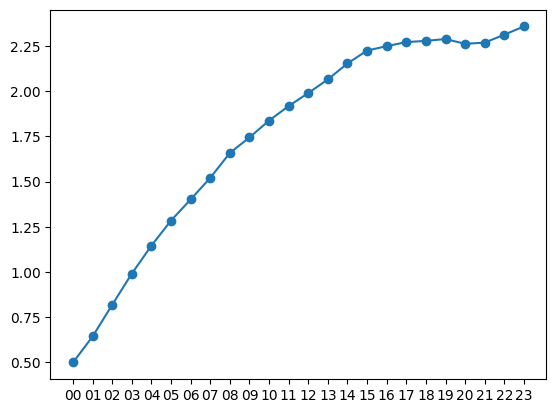

In [23]:
# Evaluate model and get scores
predictions, score, scores = evaluate_model(model, train, test, n_input, scaler)

print(predictions)

# summarize scores
summarize_scores('lstm', score, scores)

# plot scores
hours = ['00', '01', '02', '03', '04', '05', '06', '07', '08', '09', '10', '11', '12', '13',
         '14', '15', '16', '17', '18', '19', '20', '21', '22', '23']
plt.plot(hours, scores, marker='o', label='lstm')
plt.show()

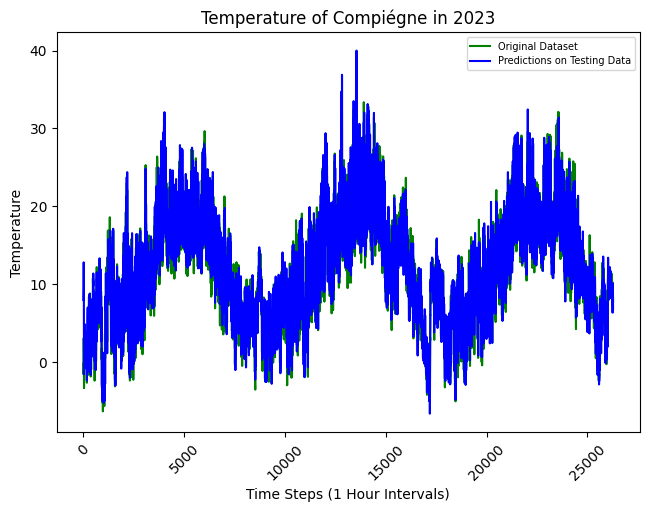

In [24]:
flattened_predictions = predictions.flatten()

# Plot baseline and predictions

plt.plot(dataset_testing['T2m'].values, 'g', label='Original Dataset')
plt.plot(flattened_predictions, 'b', label='Predictions on Testing Data')
plt.legend(fontsize=7)

plt.xticks(rotation=45)  # Rotate x-axis labels for clarity
plt.tight_layout()  # Adjust layout to prevent clipping
plt.xlabel('Time Steps (1 Hour Intervals)')
plt.ylabel('Temperature')
plt.title('Temperature of Compiégne in 2023')
plt.show()

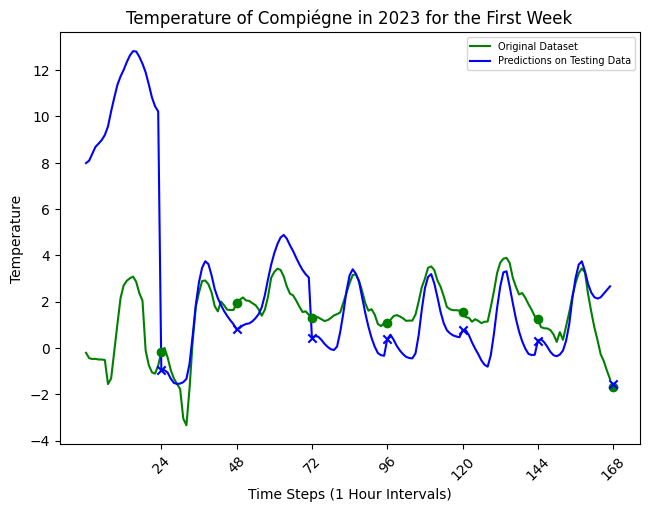

In [25]:
# Plot baseline and predictions for the first 168 timesteps
plt.plot(dataset_testing['T2m'].values[:168], 'g', label='Original Dataset')  # Slice the first 168 timesteps
plt.plot(flattened_predictions[:168], 'b', label='Predictions on Testing Data')  # Slice the first 168 timesteps

# Define the tick positions and labels
tick_positions = [24, 48, 72, 96, 120, 144, 168]
tick_labels = [str(tick) for tick in tick_positions]  # Convert to strings for labeling

# Get the y-values corresponding to the x-tick positions
original_y_values = dataset_testing['T2m'].values[tick_positions]
predicted_y_values = flattened_predictions[tick_positions]

# Add pins (markers) at xtick locations
plt.scatter(tick_positions, original_y_values, color='g', marker='o', zorder=3)
plt.scatter(tick_positions, predicted_y_values, color='blue', marker='x', zorder=3)

# Customize the plot
plt.legend(fontsize=7)
plt.xticks(tick_positions, tick_labels, rotation=45)  # Set tick positions and labels
plt.tight_layout()  # Adjust layout to prevent clipping
plt.xlabel('Time Steps (1 Hour Intervals)')
plt.ylabel('Temperature')
plt.title('Temperature of Compiégne in 2023 for the First Week')
plt.show()